# Quarterly QA on Philips Scanners

This is performed on the Philips' 1.5L bottle phantom in the most frequently used head coil - either the standard Head 20 element coil (MR21, MR22) or the 32 channel head coil (MR12). These are used for the Philips coil QA and can be easily and reproducibly positioned using the dedicated Philips plastic mount.

Where 1.5L bottle is not available then the slightly wider 2L bottle in the same holder should be used. This variant may be specified in the analysis below.

The bandwidth used should be approximately scaled with the field strength so 130Hz at 1.5T and 260Hz at 3.0T.

The quarterly QA consists of the following scans:
 - SE, 2 acquisitions (dynamic), with coil intensity correction on and 3 delayed reconstructions:
   - individual element images with no uniformity correction applied -> SNR
   - combined image with no uniformity correction applied -> SNR
   - combined image with uniformity correction applied -> uniformity, XY gradients, ghosting
 
and optionally:
 - EPI, 60+ acquisitions, ghosting and long term stability, eddy currents and shim (distortion)

The acquisitions/reconstructions should have the following labels in the protocol to make them easier to identify:
 - `QQA_SNR_ELEMENTS/COMBINED/COMBINED_UNIFORM`
 - `QQA_EPI`

In [1]:
# Patient details file yaml/json
import yaml

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams['lines.linewidth'] = 0.75

import numpy as np
import pandas as pd

from datetime import datetime, timedelta

def df_repr_latex(self):
    return '\n'.join([
        r'\begin{center}',
        r'\vspace{5mm}',
        r'{\small{%s}}' % self.to_latex(),
        r'\vspace{5mm}'
        r'\end{center}',
    ])
pd.DataFrame._repr_latex_ = df_repr_latex
from pandas.io.formats.style import Styler
Styler._repr_latex_ = lambda s: s.data._repr_latex_()
pd.set_option('display.precision', 2)

class HTMLLatex:
    def __init__(self, html, latex):
        self.html = html
        self.latex = latex
    def _repr_html_(self): return self.html
    def _repr_latex_(self): return self.latex
NewPage = HTMLLatex('<hr>', r'\clearpage\newpage')

from IPython.display import display, HTML, Latex

from mriqa.phantoms import PHILIPS1L5BOTTLE, PHILIPS2LBOTTLE
from mriqa.dcmio import fetch_series, coil_elements, qa_date, scanner_operator, larmor_frequency, software_versions
from mriqa.tools import show_montage, watermark

from mriqa.reports import (
    ghosting_report, uniformity_report, noise_correlation_report,
    circularity_report, snr_report_multi
)

# Watermark
wm = watermark()
display(pd.DataFrame(
    {'Watermark': list(wm.values())},
    index=wm.keys()
))


def show_test_result(passed):
    if passed:
        return HTMLLatex(
            '<b>Test Result - <span style="color:green">ACCEPTABLE</span></b>',
             r'\textbf{Test Result -- \color{green}ACCEPTABLE}'
        )
    else:
        return HTMLLatex(
            '<b>Test Result - <span style="color:red">FAILED</span></b>',
             r'\textbf{Test Result -- \color{red}FAILED}'
        )

Watermark
CalculationTime  2020-07-29T10:10:39+01:00
User                    birchhub/elberthol
PythonVersion                CPython 3.7.7
Platform           Linux 4.15.0-76-generic
mriqa                                0.2.6
dcmextras                            0.2.6
pydicom                              2.0.0
scipy                                1.5.1
numpy                               1.19.0
skimage                             0.17.2

The phantom used can specified here.

In [2]:
phantom = PHILIPS2LBOTTLE

The details needed to fetch the QA scans from the DICOM server are specified in a [yaml](https://en.wikipedia.org/wiki/YAML) text file `study.yml` in the same directory as this notebook.

### Series Details
The Patient ID, the Study ID and the Series Numbers of the QA scans.

In [3]:
with open('study.yml') as fp:
    study_info = yaml.safe_load(fp)
patid = study_info['PatID']
studyid = study_info['StudyID']
series = study_info['Series']

dobj = fetch_series(patid, studyid, sernos=series['Signal_Combined'], imagesonly=True)[0]

scanner, date_of_scan, operator = dobj.StationName, qa_date(dobj), scanner_operator(dobj, default='BIRCH')
display(
    pd.DataFrame(
        {'Details':[scanner, date_of_scan, operator, patid, studyid] + list(series.values())}, 
        index=['Scanner', 'Date', 'Operator', 'Patient', 'Study'] + list(series.keys())
    )
)

Details
Scanner              PHILIPS-VL9UFAM
Date                        20200319
Operator                       BIRCH
Patient          AQA20200319NBTMR12A
Study                      632407741
Signal                        [1603]
Signal_Combined               [1605]
Noise                           None
Noise_Combined                  None
Geometry                      [1604]

After running this notebook a summary of the results and any recommendations should be entered below.

# Summary

The following tests were performed as part of the quarterly checks:

 - Head Coil SNR -- PASSED
 - Distortion and Scaling -- PASSED
 - Ghosting -- PASSED
 - Head Coil Uniformity (Axial) -- PASSED

### Recommended Actions

No actions necessary.

In [25]:
qqadate = (datetime.strptime(date_of_scan, '%Y%m%d') + timedelta(days=92)).strftime('%B %Y')

text = f'''
This machine is next due for quarterly QA tests in {qqadate}.
'''
HTMLLatex(text, text)

----

In [26]:
text = f'''
BIRCH
Medical Physics & Bioengineering, UHBW
{datetime.strptime(date_of_scan, '%Y%m%d').strftime('%B %Y')}
'''

HTMLLatex(
    f'<pre>{text}</pre>',
    '\n'.join([
        r'\begin{verbatim}',
        text,
        r'\end{verbatim}'
    ])
)

In [27]:
NewPage

# Detailed Results
The detailed results for each of the tests run are presented below.

----

## Head Coil SNR

We have separate images corresponding to the individual elements of the receive-only headcoil. We expect the images to be extremely non-uniform and also that some will be much brighter than others depending on the sensitivity of the element at the position of the (single) acquired slice. There should however be some intensity in all the images and the absence of any signal at all in an image is an indication of a faulty element.

### Individual coil element images
The images from each element of the array coil before combination are shown below.

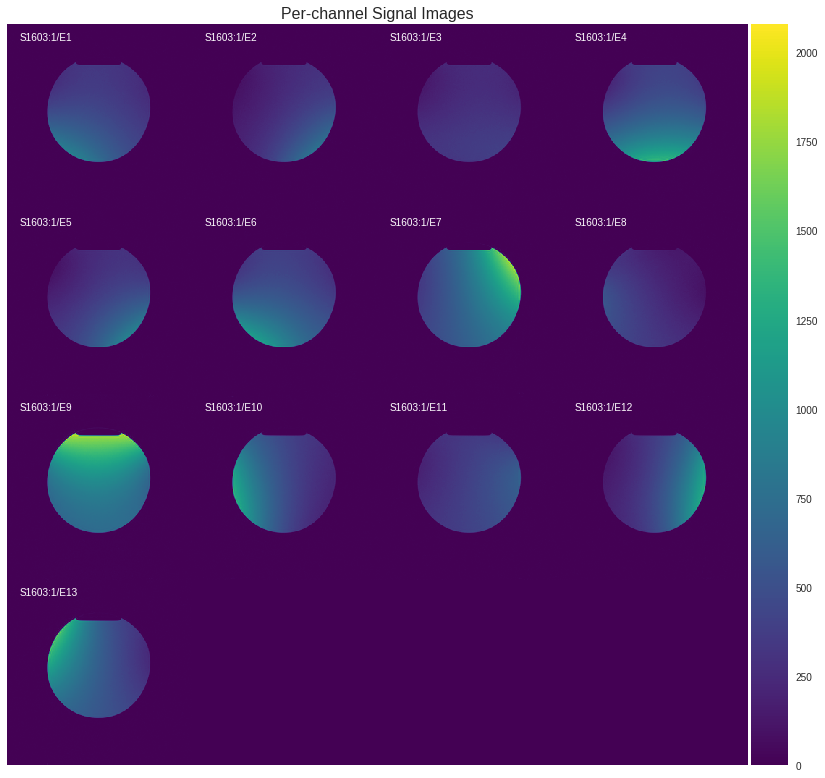

In [28]:
# Assume just one element
dobjs = fetch_series(patid, studyid, sernos=series['Signal'], imagesonly=True)
show_montage(dobjs, None, op='mean', cmap='viridis', title='Per-channel Signal Images');

In [29]:
show_test_result(True)

All coils show some signal intensity. They are expected to be non-uniform with variation in signal intensity depending on each coil's sensitivity at the slice position.

In [30]:
NewPage

There are various ways to estimate the overall SNR of the coil. Here, we use the subtraction method but still use a backgound region for the noise component. This assumes the noise is stationary, which precludes the use of any non-linear filters such as for intensity normalisation or geometric distortion correction. On the other hand, it is insenstive to scan to scan variations in the phantom foreground.

As we have the individual coil element images available, we combine them here as root-sum-of-squares and check that the background noise distributions are as expected, both for a single image and for a subtracted pair. The former is expected to be a central-$\chi$ distribution and the latter at least symmetric by construction.

The quoted SNR figures are for the central 50% and 75% (by radius) of the phantom. The noise level is derived from a background region in the subtraction image.

### Signal to Noise Ratio
The histograms below show the noise in the indicated background regions for a single image (left) and the difference between two identical acquisitions (right). The SNR values in the central 50% and 75% of the phantom are shown in the table.

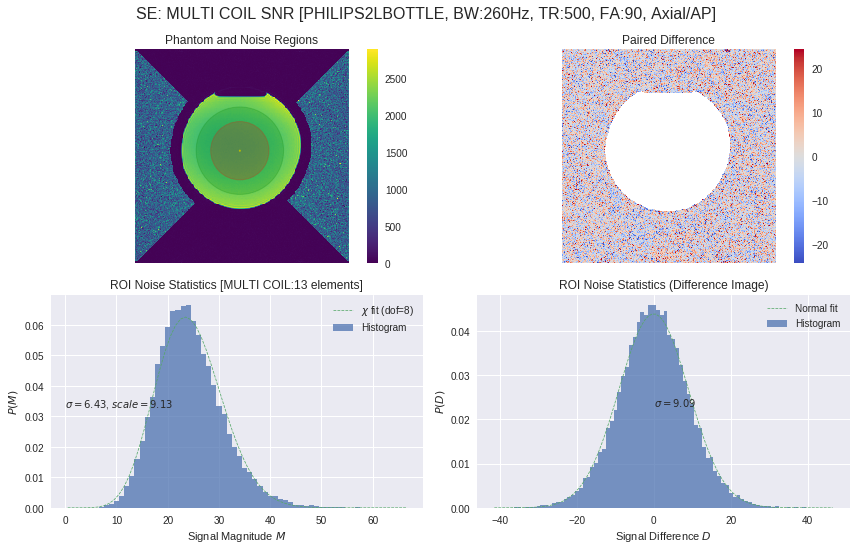

MULTI COIL
0.50      309.58
0.75      319.90

In [31]:
# SNR (uncombined channels)
dobjs = fetch_series(patid, studyid, sernos=series['Signal'], imagesonly=True)
snr_report_multi(dobjs, None, phantom=phantom)

In [32]:
show_test_result(True)

The combined element images have the expected noise characteristics. The signal-to-noise ratio calculated in ROIs encompassing the central 50% and 75% of the phantom is consistent with previous values for this scanner.

----

In [33]:
NewPage

There is limited scope for assessing the geometric distortion using just the uniform cylindrical phantom. However, we can measure the circularity of the phantom cross section by fitting the edge in the image to a sub-pixel precision and determining the distance between opposite points on the edge as a function of angle. If we fit a sinusoid function to the diameters function we can use that as en estimate of the non-circularity of the phantom.

The analysis should be done on the uniformity corrected images to minimise errors in the edge determination arising from intensity variations. The results will depend on whether distortion correction has also been applied.

The left hand plot shows the edge positions as a function of angle and the right hand plot shows the phantom diameters along with a sinusoidal fit indicating eccentricity.

Owing to the relatively poorly defined geometry of the Philips bottle phantoms only gross deviations of scale or large eccentricities will be clear indications of system gradient issues. A more careful evaluation of distortion and scale is performed in the annual assessment.  

## Phantom Circularity (Scale and Distortion)
The average diameter and circularity of an axial slice of the cylindrical bottle phantom are shown below.

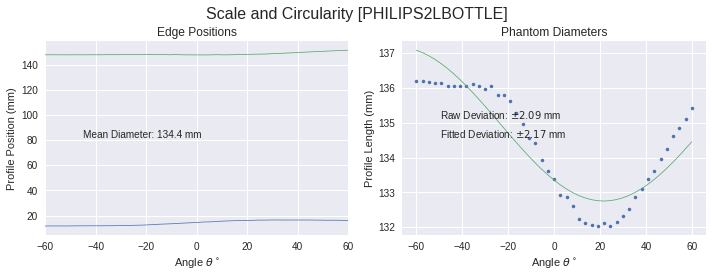

PHILIPS2LBOTTLE
Nominal                   133.00
Diameter                  134.35
Deviation                   2.09
FittedDeviation             2.17

In [34]:
dobjs = sorted(
    fetch_series(patid, studyid, sernos=series['Geometry'], imagesonly=True),
    key=lambda x: (int(x.SeriesNumber), int(x.AcquisitionNumber))
)
circularity_report(dobjs[0], phantom=phantom, excluded_sector=60).T

In [35]:
show_test_result(True)

The mean diameter is within 1% of the expected value and the deviation from circular is acceptable.

----

In [36]:
NewPage

In the annual tests the image ghosting is assessed on a small GE sphere with a variety of sequences using the approach of AAPM report 100. We use the same analysis here but restrict ourselves to a spin echo acquisition of the Philips bottle.

The use of intensity normalisation or distortion will have a small effect on the results so, by preference, the combined but uncorrected images are used

The test compares the intensity in predefined ghost and background areas of the image, the former along the in-plane phase encoding direction where ghosts might be expected. The actual values obtained for the ghosting ratio will vary somewhat according to exactly where the ghosting regions of interest are defined. In particular, any ringing like artefacts close to the phantom will only be detected if the region of interest is equally close to the phantom edge. Nyquist ghosting on the other hand is best detected with an ROI that comprises the phantom shifted by N/2 in the phase encoding direction.

In addition, as the test compares the signal in background regions of interest along the phase encoding and the readout direction it is only sensitive to these separately (generally in the phase encoding direction). Anything that is manifest on both axes will cancel out in the subtraction.

The difference between the two regions is presented as a fraction of the average foreground signal in the phantom.

## Ghosting
Image ghosting is assessed on an axial slice imaged with a standard spin echo. The ghosting ratio is the proportion of signal in the ghosts as a fraction of the signal in the phantom. 

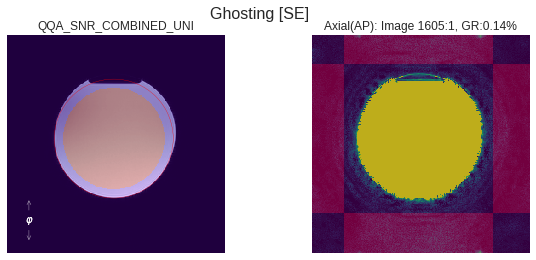

Series                           1605
Protocol     QQA_SNR_COMBINED_UNIFORM
Orientation                     Axial
Sequence                           SE
GhostRatio                       0.14

In [37]:
# BOTTLE: Ghosting
dobjs = fetch_series(patid, studyid, sernos=series['Signal_Combined'], imagesonly=True)
df = ghosting_report([dobjs[0]], phantom=phantom)
df[['Protocol', 'Orientation', 'Sequence', 'GhostRatio']].T

In [38]:
show_test_result(True)

The level of ghosting is acceptable.

----

In [39]:
NewPage

The image uniformity is evaluated by taking profiles in the vertical and horizontal directions through the centre of the phantom. For a full assessment all three axes would be measured in an oil filled sphere. In this case though we consider only the axial plane. In addition, although the test is intented as a measure of receive coil non-uniformities, the Philips bottle phantom is filled with an aqueous solution. This means that at higher fields, a contribution may be expected for non-uniformity in the body coil transmit field.

In any case, the images are root-mean-square combinations of a large number of local coil elements, which inevitably means there will be considerable non-uniformity. Typically the images are brighter away from the centre towrds the coil elements. Results here are for both the *raw* non-uniformity and for images reconstructed with intensity normalisation. This may be taken as an assessment of how well the normalisation compensates for the large intrinsic non-uniformity. 

## Uniformity

The axial uniformity is tested in on a uniform cylinder both before and after the coil sensitivity-based uniformity correction is applied.

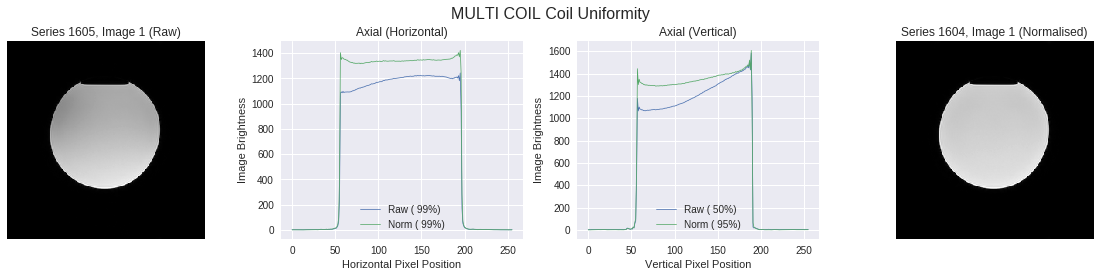

In [40]:
raw_dobjs = fetch_series(patid, studyid, sernos=series['Signal_Combined'], imagesonly=True)
psn_dobjs = fetch_series(patid, studyid, sernos=series['Geometry'], imagesonly=True)
df = uniformity_report(raw_dobjs=raw_dobjs[:1], psn_dobjs=psn_dobjs[:1], phantom=phantom)

In [41]:
df_raw = df[['XUniformityRaw','YUniformityRaw','NEMAUniformityRaw']].rename(
    columns={
        'XUniformityRaw':'X Uniformity',
        'YUniformityRaw':'Y Uniformity',
        'NEMAUniformityRaw':'NEMA Uniformity'},
    index={'Axial':'Raw'}
)

df_corrected = df[['XUniformityNorm', 'YUniformityNorm', 'NEMAUniformityNorm']].rename(
    columns={
        'XUniformityNorm':'X Uniformity',
        'YUniformityNorm':'Y Uniformity',
        'NEMAUniformityNorm':'NEMA Uniformity'},
    index={'Axial':'Corrected'}
)

pd.concat([df_raw, df_corrected])

X Uniformity  Y Uniformity  NEMA Uniformity
Orientation                                             
Raw                 98.58         50.37            91.32
Corrected           99.30         94.81            97.03

In [42]:
show_test_result(True)

As expected for a multi-element coil the uncorrected image is significantly non-uniform. However, the uniformity correction provides adequate compensation.

----